<br/>
<div align="center" >

![Confusion Matrix](../images/ENSC.png)

# <u> ENSC Parcours IA </u>
## Data Challenge - Détection de clics d'odontocètes

</div>

As part of the [Artificial Intelligence specialization](https://3aia.notion.site/3aia/Parcours-3A-IA-2023-9917027c682b457dae71fea68c067ad1) at the [ENSC](https://ensc.bordeaux-inp.fr/fr), we participated in a data challenge provided by the University of Toulon in the [ChallengeData](https://challengedata.ens.fr/) website. 

This challenge specifically aims to detect the presence of odontoceti clicks in underwater audio recordings in the Caribbean sea.

## Import necessary libraries

In [1]:
import pandas as pd
from pathlib import Path
import os
import librosa
import librosa.display
import librosa.feature as feat
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import soundfile
from scipy import signal
import seaborn as sns
%matplotlib inline
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [116]:
# Set the path to the downloaded data
download_path = Path.cwd() / ".dataset"

# Read labels file
labels_file = download_path / "Y_train_ofTdMHi.csv"
df = pd.read_csv(labels_file)

# Construct file path by concatenating folder and file name
df["relative_path"] = str(download_path) + "/X_train/" + df["id"]

# Drop id column (replaced it with relative_path)
df.drop(columns=["id"], inplace=True)

df.rename(columns={"pos_label": "label"}, inplace=True)

# invert relative_path and label columns positions
df = df[["relative_path", "label"]]
display(ipd.Markdown(f"### There are **_{len(df)}_** audio files in the dataset."))

table = f"""
Here is the split into good and bad signals:
| Label   | Count   |
|:-------:|:-------:|
| 0       | {df['label'].value_counts()[0]} |
| 1       | {df['label'].value_counts()[1]} |"""
display(ipd.Markdown(table))

### There are **_23168_** audio files in the dataset.


Here is the split into good and bad signals:
| Label   | Count   |
|:-------:|:-------:|
| 0       | 13718 |
| 1       | 9450 |

Take one file to check mfcc with librosa

Audio data shape: (51200,), Sample rate: 256000


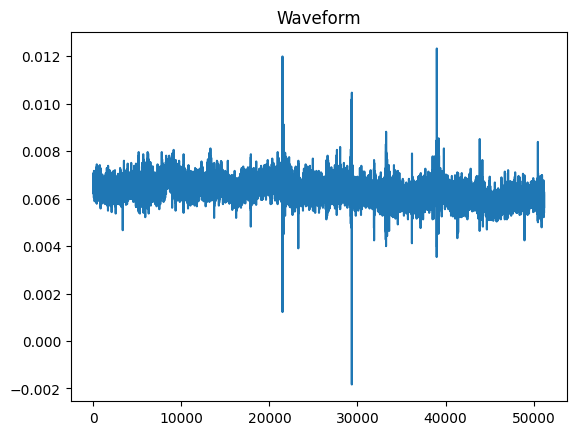

In [117]:
# Get the file and load it
file_path = df.loc[0, "relative_path"]
audio_data, sr = librosa.load(file_path, sr=None)
print(f"Audio data shape: {audio_data.shape}, Sample rate: {sr}")

# Plot the audio signal
fig, ax = plt.subplots(nrows=1, sharex=True)
plt.plot(audio_data)
plt.title('Waveform')
plt.show()

In [118]:
mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
mfccs

/Users/tristangclvs/Documents/ENSC/3A/S9/Spé IA/projet/spe_IA_clics_odontocetes/.venv/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


array([[-5.80592590e+02, -6.18172546e+02, -7.06206238e+02, ...,
        -7.06523865e+02, -6.18886719e+02, -5.86460754e+02],
       [ 1.06721710e+02,  9.30850372e+01,  3.27370491e+01, ...,
         3.11220779e+01,  8.59332275e+01,  1.04781303e+02],
       [-3.43419304e+01, -3.15824070e+01, -4.91998596e+01, ...,
        -4.22441788e+01, -3.49739075e+01, -3.85120888e+01],
       ...,
       [-1.67548931e+00,  1.78555739e+00,  7.10839319e+00, ...,
         1.10129423e+01,  2.24370122e+00, -1.23915851e+00],
       [-5.47950172e+00, -2.53973007e+00,  1.23632467e+00, ...,
         1.04649715e+01, -2.40652680e-01, -3.20498276e+00],
       [-7.75990438e+00, -6.79572582e+00, -7.50377417e-01, ...,
        -3.59400272e+00, -1.12350445e+01, -1.08889484e+01]], dtype=float32)

In [119]:
class AudioUtil:
    """Static class for audio processing helper functions."""
    
    @staticmethod
    def open(audio_file: str):
        """Load an audio file. Return the signal as a tensor and the sample rate"""
        sig, sr = librosa.load(audio_file, sr=256000)
        return (sig, sr)
    
    @staticmethod
    def get_audio_duration(sig, sr):
        """Return the duration of an audio signal in seconds"""
        return librosa.get_duration(sig, sr)
    
    @staticmethod
    def mel_spectro_gram(sig: np.array, sr: int, n_mels=32, n_fft=1024):
        """Generate a Spectrogram"""
        # get mel spectrogram
        spec = librosa.feature.melspectrogram(y=sig, sr=sr)
        spec = librosa.amplitude_to_db(spec)
        return spec
    
    @staticmethod
    def extract_mfccs(file_path):
        audio_data, sr = librosa.load(file_path, sr=100000)
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13, n_mels=2048)
        mfccs_scaled_features = np.mean(mfccs.T,axis=0)
        return mfccs_scaled_features
    
    @staticmethod
    def get_audio_specs_size(spec):
        """Return the size of a spectrogram image"""
        return spec.shape
    
    @staticmethod
    def plot_mel_spectro_gram(spec: np.array, sr: int):
        """Plot a Spectrogram"""
        # plot mel spectrogram
        fig, ax = plt.subplots()
        S_dB = librosa.power_to_db(spec, ref=np.max)
        img = librosa.display.specshow(S_dB, x_axis='time',
                                y_axis='mel', sr=sr,
                                ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Mel-frequency spectrogram')

In [120]:
def save_spectrograms(nb_files = len(df)):
    audio_util = AudioUtil()
    label_files = np.empty(0)
    audio_mfccs = []
    features_and_labels = []
    print("Starting mfccs generation...")
    for line_num in tqdm(range(nb_files), unit="file", desc="Generating mfccs"):
        file_path = df.loc[line_num, "relative_path"]
        mfccs = audio_util.extract_mfccs(file_path)
        audio_mfccs.append(mfccs)
        label_files = np.append(label_files, df.loc[line_num, "label"])
        features_and_labels.append((mfccs, df.loc[line_num, "label"]))
    print("Mfccs generated !", end='\n\n')

    print("Saving mfccs...")
    os.mkdir("numpy_data") if not os.path.exists("numpy_data") else None
    np.save(os.path.join("numpy_data", "audio_mfccs.npy"), audio_mfccs)
    np.save(os.path.join("numpy_data", "label_files.npy"), label_files)
    print("Mfccs saved !")
    features_and_labels = pd.DataFrame(features_and_labels, columns=["mfccs", "label"])

    print("Global shape : ", features_and_labels.shape)
    print(features_and_labels.head())

# save_spectrograms()

In [121]:
def extract_features(audio_file):
    sig, sr = soundfile.read(audio_file)

    sos = signal.butter(6, [5000, 100000], 'bandpass', fs=sr, output='sos')
    sig = signal.sosfiltfilt(sos, sig)
    rms = feat.rms(y=sig) 
    sc = feat.spectral_centroid(y=sig, sr=sr)
    sb = feat.spectral_bandwidth(y=sig,sr=sr)
    sf = feat.spectral_flatness(y=sig)

    features = [np.mean(rms), np.std(rms), np.min(rms), np.max(rms),\
                np.mean(sc), np.std(sc), np.min(sc), np.max(sc),\
                np.mean(sb), np.std(sb), np.min(sb), np.max(sb),\
                np.mean(sf), np.std(sf), np.min(sf), np.max(sf)]
    return features

def save_features(nb_files = len(df)):
    features_and_labels = []
    for line_num in tqdm(range(nb_files), unit="file", desc="Generating features"):
        label_file = df.loc[line_num, "label"]
        file_path = df.loc[line_num, "relative_path"]
        features = extract_features(file_path)
        features_and_labels.append((features, label_file))

    features_and_labels = pd.DataFrame(features_and_labels, columns=["features", "label"])
    print("Global shape : ", features_and_labels.shape)
    print(features_and_labels.head())

    print("Saving features...")
    os.mkdir("numpy_data") if not os.path.exists("numpy_data") else None
    np.save(os.path.join("numpy_data", "features.npy"), features_and_labels["features"])
    print("Features saved !")

# save_features()

In [122]:
def get_spectrograms_from_file(file_path):
    audio_specs = np.load(file_path)
    return np.array(audio_specs.tolist())

def get_labels_from_file(file_path):
    label_files = np.load(file_path)
    return np.array(label_files.tolist())

def get_features_from_file(file_path):
    features = np.load(file_path, allow_pickle=True)
    return np.array(features.tolist())

X = get_features_from_file(os.path.join(os.getcwd(),"numpy_data", "features.npy"))
# X = pd.DataFrame(get_spectrograms_from_file(os.path.join(os.getcwd(),"numpy_data", "audio_mfccs.npy")))
y = get_labels_from_file(os.path.join(os.getcwd(),"numpy_data", "label_files.npy"))

print(X.shape)
print(y.shape)
assert len(X[0]) == 16, "Wrong number of features !"

(23168, 16)
(23168,)


Make features as columns

In [123]:
features=["rms_mean","rms_std", "rms_min", "rms_max", "sc_mean", "sc_std", "sc_min", "sc_max", "sb_mean", "sb_std", "sb_min", "sb_max", "sf_mean", "sf_std", "sf_min", "sf_max"]
X_with_features_columns = pd.DataFrame(columns=features)

for i, X_element in tqdm(enumerate(X), unit=" Element", total=X.shape[0]):
    for j, feature in enumerate(X_element):
        X_with_features_columns.loc[i, features[j]] = feature
X = X_with_features_columns

100%|██████████| 23168/23168 [00:29<00:00, 780.68 Element/s]


Split the dataset into training, testing (and validation) datasets

In [124]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.75)
# X_train, X_validation, y_train, y_validation=train_test_split(X_train,y_train,train_size=0.8, random_state=64)

print(f"X_train contains {X_train.shape[0]} files of shape {X_train.shape[1:]}")
print(f"X_test contains {X_test.shape[0]} files of shape {X_test.shape[1:]}", end='\n\n')
# print(f"X_validation contains {X_validation.shape[0]} files of shape {X_validation.shape[1:]}")

print(f"Features are : {X_train.columns.tolist()}") 
X_train.head()

X_train contains 17376 files of shape (16,)
X_test contains 5792 files of shape (16,)

Features are : ['rms_mean', 'rms_std', 'rms_min', 'rms_max', 'sc_mean', 'sc_std', 'sc_min', 'sc_max', 'sb_mean', 'sb_std', 'sb_min', 'sb_max', 'sf_mean', 'sf_std', 'sf_min', 'sf_max']


,rms_mean,rms_std,rms_min,rms_max,sc_mean,sc_std,sc_min,sc_max,sb_mean,sb_std,sb_min,sb_max,sf_mean,sf_std,sf_min,sf_max
13536,0.000332,0.000032,0.000219,0.000393,30702.030623,1572.580532,28470.014592,36850.646852,24030.567117,764.07085,22303.222473,27100.27179,0.014827,0.005633,0.00997,0.049404
1468,0.00034,0.000034,0.000225,0.000414,32608.137948,1606.662465,29800.845142,38906.10698,24728.087656,512.30152,23324.005944,26382.538997,0.013381,0.003185,0.008242,0.027808
9719,0.00059,0.000132,0.000333,0.001038,34680.066318,3075.335606,22736.514404,43918.748093,24490.830198,1036.674192,21397.083612,26696.343053,0.017704,0.007701,0.003582,0.081164
7609,0.000402,0.000083,0.000256,0.000646,30615.646103,1677.058799,28042.575955,35011.665955,24496.124273,1244.374612,18062.667725,26088.507472,0.009607,0.002646,0.00567,0.018983
14763,0.000957,0.000205,0.00058,0.001453,37738.196099,4574.268149,27684.385163,49148.536777,24785.228915,927.791545,22300.302407,27851.902961,0.019865,0.013248,0.005781,0.11285


In [125]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

n_fold = 2
model = LogisticRegression()
accuracy_scores = []
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X))

X_train, X_test, y_train, y_test = [], [], [], []
skf = StratifiedKFold(n_splits=n_fold)

for train, test in skf.split(X_scaled, y):
    X_train.append(train), X_test.append(test), y_train.append(train), y_test.append(test)

print("N° of folds: ", len(X_train))
print("N° of audios per fold: ",X_train[0].shape[0])

for i in tqdm(range(n_fold), unit=" fold", desc="Training"):
    model.fit(X_train[i].reshape(-1,1), y_train[i])
    # Make predictions on the validation set
    y_pred = model.predict(X_test[i].reshape(-1, 1))
    
    # Calculate the accuracy score for this fold
    acc = accuracy_score(y_test[i], y_pred)
    
    # Append the accuracy score to the list
    accuracy_scores.append(acc)

print("Accuracy scores: ", accuracy_scores)

N° of folds:  2
N° of audios per fold:  11584


Training:  50%|█████     | 1/2 [01:04<01:04, 64.32s/ fold]


KeyboardInterrupt: 

Helper function for prediction on random sample

In [ ]:
import random
def predict_on_random_sample(classifier, X_test, y_test):
    random_index = random.randint(0, len(X_test)-1)
    while random_index not in X_test.index:
        random_index = random.randint(0, len(X_test)-1)
    sample = X_test.loc[random_index]
    print("Correct ✅" if classifier.predict([sample])[0] == y_test[random_index] else "Incorrect ❌")
    print(f'Prediction for sample {random_index:4}: {int(classifier.predict([sample])[0])}')
    print(f'Actual label              : {int(y_test[random_index])}')

    prob_table = f"""
    Probabilities for each class:
     _________________________
    | Label   | Probability   |
    |---------|---------------|
    | 0       | {f"{classifier.predict_proba([sample])[0][0]:.3f}":13} |
    | 1       | {f"{classifier.predict_proba([sample])[0][1]:.3f}":13} |
    |_________|_______________|"""
    display(ipd.Markdown(prob_table))


We will want to display the confusion matrixes after fitting the models

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues):
    plt.figure(figsize=(6,6))
    score_classifier = classifier.score(X_test, y_test)
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=[0,1],
        cmap=cmap,
        normalize='true',
    )
    plt.ylabel('Actual label', fontsize = 17);
    plt.xlabel('Predicted label', fontsize = 17);
    plt.title(f'Accuracy Score: {score_classifier:.3f}', size = 17);
    plt.tick_params(labelsize= 15)

## Scale data

For some models (e.g. Logistic Regression), data needs to be scaled. In order to do that we will use scikit-learn's StandardScaler.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train.head()

## <div align="center"> ---------- Logistic Regression ---------- </div>

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")

#### Try a prediction on a random sample

In [ ]:
predict_on_random_sample(log_reg, X_test_scaled, y_test)

#### Score of this model

In [ ]:
score_log_reg = log_reg.score(X_test_scaled, y_test)
print(f"Logistic Regression score: {score_log_reg:.3f}")

#### Print the confusion matrix on test set

In [ ]:
plot_confusion_matrix(log_reg, X_test_scaled, y_test)

#### Check the ROC AUC score

In [ ]:
print(f"ROC AUC Score with Logistic Regression : {roc_auc_score(y_test, y_pred_log_reg)}")
print(f"F1 Score with Logistic Regression      : {f1_score(y_test, y_pred_log_reg)}")

## <div align="center"> ---------- Decision Tree ---------- </div>

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=15, random_state=0)
tree_clf.fit(X_train.values, y_train)
y_pred_tree = tree_clf.predict(X_test.values)
print(f"Accuracy: {tree_clf.score(X_test.values, y_test)}")

#### Try a prediction on a random sample

In [ ]:
predict_on_random_sample(tree_clf, X_test, y_test)

#### Measure the model performance

In [ ]:
score_tree_clf = tree_clf.score(X_test.values, y_test)
print(f"Decision Tree score: {score_tree_clf:.3f}")

#### Try to find the optimal `max_depth`

In [ ]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 15))

# List to store the average RMSE for each value of max_depth:
accuracy = []

for depth in tqdm(max_depth_range, unit='depth', desc='Testing max_depth'):
    
    clf = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0)
    clf.fit(X_train, y_train)

    score = clf.score(X_test, y_test)
    accuracy.append(score)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,7));

ax.plot(max_depth_range,
        accuracy,
        lw=2,
        color='k')

ax.set_xlim([1, len(max_depth_range)])
ax.set_ylim([.50, 1.00])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')

yticks = ax.get_yticks()

y_ticklist = []
for tick in yticks:
    y_ticklist.append(str(tick).ljust(4, '0')[0:4])
ax.set_yticklabels(y_ticklist)
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('Accuracy', fontsize = 24)
fig.tight_layout()

#### Visualize the decision tree

In [ ]:
from sklearn import tree
# Caution on the max_depth parameter, it makes the tree unreadable if too big
# tree.plot_tree(tree_clf) 

#### Plot the confusion matrix

In [ ]:
plot_confusion_matrix(tree_clf, X_test.values, y_test, cmap=plt.cm.Greens)

#### Check the ROC AUC & F1 scores

In [ ]:
print(f"ROC AUC Score with Decision Tree : {roc_auc_score(y_test, y_pred_tree):.3f}")
print(f"F1 Score with Decision Tree      : {f1_score(y_test, y_pred_tree):.3f}")

## <div align="center"> ---------- Bagged Tree ---------- </div>

In [ ]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier()

bag_clf.fit(X_train.values, y_train)
y_pred_bag = bag_clf.predict(X_test.values)
print(f"Accuracy: {bag_clf.score(X_test.values, y_test)}")

#### Try prediction on a random sample

In [ ]:
predict_on_random_sample(bag_clf, X_test, y_test)

#### Score of this model

In [ ]:
score_bag = bag_clf.score(X_test.values, y_test)
print(f"Logistic Regression score: {score_bag:.3f}")

#### Confusion Matrix

In [ ]:
plot_confusion_matrix(bag_clf, X_test.values, y_test, cmap=plt.cm.Purples)

#### Check ROC AUC & F1 scores

In [ ]:
print(f"ROC AUC Score with Bagged Tree : {roc_auc_score(y_test, y_pred_bag):.3f}")
print(f"F1 Score with Bagged Tree      : {f1_score(y_test, y_pred_bag):.3f}")

## <div align="center"> ---------- Random Forest ---------- </div>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100)
forest_clf.fit(X_train.values, y_train)
y_pred_forest = forest_clf.predict(X_test.values)
print(f"Accuracy: {accuracy_score(y_test, y_pred_forest)}")

#### Try predicting on a random sample

In [ ]:
predict_on_random_sample(forest_clf, X_test, y_test)

In [ ]:
score_forest = forest_clf.score(X_test.values, y_test)
print(f"Logistic Regression score: {score_forest:.3f}")

#### Confusion Matrix

In [ ]:
plot_confusion_matrix(forest_clf, X_test.values, y_test, cmap=plt.cm.Oranges)

#### Check the ROC AUC & F1 scores

In [ ]:
print(f"ROC AUC Score with Random Forest : {roc_auc_score(y_test, y_pred_forest):.3f}")
print(f"F1 Score with Random Forest      : {f1_score(y_test, y_pred_forest):.3f}")

#### Get the importance of the features

In [ ]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(forest_clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
importances.head()

## XGClassifier

In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train.values, y_train)
y_pred_xgb = xgb_clf.predict(X_test.values)
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")


### Predict on a random sample

In [ ]:
predict_on_random_sample(xgb_clf, X_test, y_test)

### Score of this model

In [ ]:
score_xgb = xgb_clf.score(X_test.values, y_test)
print(f"XGB score: {score_xgb:.3f}")

### Print the confusion Matrix

In [ ]:
plot_confusion_matrix(xgb_clf, X_test.values, y_test, cmap=plt.cm.Reds)

#### Check ROC AUC & F1 scores

In [ ]:
print(f"ROC AUC Score with XGB : {roc_auc_score(y_test, y_pred_xgb):.3f}")
print(f"F1 Score with XGB      : {f1_score(y_test, y_pred_xgb):.3f}")

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
scores = cross_val_score(xgb_clf, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())
 
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

## Recap of previous models and their respective scores

In [ ]:
log_reg.get_params()
type(log_reg)

In [ ]:
# Sort descending by score
classifiers_names = ["Logistic Regression", "Decision Tree", "Bagging", "Random Forest", "XGBClassifier"]
classifiers_scores = [score_log_reg, score_tree_clf, score_bag, score_forest, score_xgb]

classifiers_f1_scores = [f1_score(y_test, y_pred_log_reg), f1_score(y_test, y_pred_tree), f1_score(y_test, y_pred_bag), f1_score(y_test, y_pred_forest), f1_score(y_test, y_pred_xgb)]

classifiers_and_scores = list(zip(classifiers_names, classifiers_scores, classifiers_f1_scores))
classifiers_and_scores.sort(key=lambda x: x[1], reverse=True)

scores_lines = [f"| **{name}** | **{score:.3f}** | **{f1:.3f}** |\n" for index, (name, score, f1) in enumerate(classifiers_and_scores)]

scores_table = f"""
<div align="center">
    <h2>Classifiers scores</h2>

| <h3>Classifier</h3>   | <h3>Score</h3>   | <h3>F1 Score</h3>   |
|:---------:|:---------------:|
{"".join(scores_lines)}
"""

display(ipd.Markdown(scores_table))

The best classifier seems to be the XGB classifier, thus we will make predictions on the test waveforms.

In [3]:
download_path = Path.cwd() / ".dataset"

# Read metadata file
labels_file = download_path / "Y_random_Xwjr6aB.csv"
df_test = pd.read_csv(labels_file)

# Construct file path by concatenating folder and file name
df_test["relative_path"] = str(download_path) + "/X_test/" + df_test["id"]
df_test.drop(columns=["id"], inplace=True)
df_test.rename(columns={"pos_label": "label"}, inplace=True)
# invert relative_path and label columns positions
df_test = df_test[["relative_path", "label"]]
print(f"There are ** {len(df_test)} ** audio files in the test dataset.", end="\n\n")
df_test.head()

There are ** 950 ** audio files in the test dataset.



,relative_path,label
0,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,0.000000
1,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,0.197364
2,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,1.000000
3,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,0.826255
4,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,0.000000


In [ ]:
from datetime import datetime
audio_util = AudioUtil()
predictions = []

for line_num in tqdm(range(len(df_test)), unit="file", desc="Predicting labels"):
    test_audio_file = df_test.loc[line_num, "relative_path"]
    test_file_features = np.array(extract_features(test_audio_file))
    
    # Predict the label of the audio file
    prediction = xgb_clf.predict(test_file_features.reshape(1, -1))

    # Print the predicted label
    if prediction > 0.5:
        predictions.append([df_test.loc[line_num, "relative_path"].split(sep='/')[-1], 1])
    else:
        predictions.append([df_test.loc[line_num, "relative_path"].split(sep='/')[-1], 0])

predictions = pd.DataFrame(predictions, columns=["id", "pos_label"])

now = datetime.now()
date = now.strftime("%d-%m-%Y_%H-%M-%S")
predictions.to_csv(f"Y_predict_{date}.csv", index=False)

<img src="https://scikit-learn.org/stable/_static/ml_map.png" />

## Time to create and train a model

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
def build_model_not_Cnn():
    model = Sequential()

    # Input layer
    model.add(Dense(256, input_shape=(40,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    # Hidden layers
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))  

    model.summary()
   
    return model


In [ ]:
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((40, 1), input_shape=(40,)))

    # Add a Lambda layer to add the batch size and channel dimensions
    model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)))

    # Add the first convolutional layer
    model.add(tf.keras.layers.Conv2D(256, kernel_size=(3, 1), activation='relu', strides=(1, 1))) 
    model.add(tf.keras.layers.Dropout(0.2))

    # Add the second convolutional layer
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu', strides=(1, 1), padding='same')) 
    model.add(tf.keras.layers.Dropout(0.2))

    # Flatten the output from the convolutional layers
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(256, activation='relu'))

    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model

model = build_model()
model.summary()
is_cnn = "CNN"

In [ ]:
# import torch
# import torch.nn as nn

# class Reshape(nn.Module):
#     def __init__(self, shape):
#         super(Reshape, self).__init__()
#         self.shape = shape

#     def forward(self, x):
#         return x.view(x.size(0), *self.shape)

# class CustomModel(nn.Module):
#     def __init__(self):
#         super(CustomModel, self).__init__()

#         self.model = nn.Sequential(
#             Reshape((1, 40)),
#             nn.Conv2d(1, 256, kernel_size=(3, 1), stride=(1, 1)),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Conv2d(256, 128, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Flatten(),
#             nn.Linear(1280, 256),  # Adjust the input size based on the output size of the previous layer
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 128),
#             nn.Dropout(0.2),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 64),
#             nn.ReLU(),
#             nn.Linear(64, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.model(x)

# def build_model():
#     return CustomModel()

# # Instantiate the model
# model = build_model()

# # Print the model summary
# print(model)


In [ ]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime 

num_epochs = 200
num_batch_size = 32

# Create an EarlyStopping callback montinotoring 'val_loss'
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_validation, y_validation), verbose=1, callbacks=[early_stopping_callback]);


In [ ]:
evaluation_results = model.evaluate(X_test,y_test,verbose=0)

for metric_name, result in zip(model.metrics_names, evaluation_results):
    print(f"{metric_name}: {result:.4f}")


In [ ]:
# Save model depending on date and accuracy
# Get date
now = datetime.now()
date = now.strftime("%d-%m-%Y_%H-%M-%S")
model.save(os.path.join(os.getcwd(),"models",f"model_{date}_{evaluation_results[1]:.4f}_{is_cnn}.h5"))

## Test the model with test files

In [ ]:
import ipywidgets as widgets
from tensorflow.keras.models import load_model
options = [model for model in os.listdir(os.path.join(os.getcwd(),"models")) if model.endswith(".h5")]
dropdown = widgets.Dropdown(options=options, value=options[0], description='Select a model:')
button = widgets.Button(description='Show selected model')

output = widgets.Output()
selected_model = model
def on_button_click(b):
    global selected_model
    with output:
        selected_model = load_model(os.path.join(os.getcwd(),"models",dropdown.value))
        print(f"Selected model: {dropdown.value}")

button.on_click(on_button_click)

display(dropdown)
display(button)
display(output)

In [ ]:
print(selected_model.summary())

In [ ]:
download_path = Path.cwd() / ".dataset"

# Read metadata file
labels_file = download_path / "Y_random_Xwjr6aB.csv"
df_test = pd.read_csv(labels_file)

# Construct file path by concatenating folder and file name
df_test["relative_path"] = str(download_path) + "/X_test/" + df_test["id"]
df_test.drop(columns=["id"], inplace=True)
df_test.rename(columns={"pos_label": "label"}, inplace=True)
# invert relative_path and label columns positions
df_test = df_test[["relative_path", "label"]]
print(f"There are ** {len(df_test)} ** audio files in the test dataset.", end="\n\n")
df_test.head()

In [ ]:
def save_spectrograms_test(nb_files = len(df_test)):
    audio_util = AudioUtil()
    labels_predicted = np.empty(0)
    files_with_labels = []
    audio_mfccs = []
    labels_files = np.empty(0)
    features_and_labels = []
    print("Starting mfccs generation...")
    for line_num in tqdm(range(nb_files), unit="file", desc="Generating mfccs"):
        file_path = df_test.loc[line_num, "relative_path"]
        file_name = file_path.split("/")[-1]
        mfccs = audio_util.extract_mfccs(file_path)
        
        audio_mfccs.append(mfccs)
        labels_files = np.append(labels_files, df_test.loc[line_num, "label"])

        single_prediction = model.predict(mfccs.reshape(1,40), verbose=0)
        labels_predicted = np.append(labels_predicted, single_prediction[0][0])
        features_and_labels.append((mfccs, df_test.loc[line_num, "label"]))

        files_with_labels.append([file_name, labels_predicted[-1]])
    print("Mfccs generated !", end='\n\n')
    
    files_with_labels = pd.DataFrame(files_with_labels, columns=["id", "label"])
    print(files_with_labels.head())
    
    # Save the csv file with the predictions
    files_with_labels.to_csv("Y_test_predictions.csv", index=False)

    print("Saving mfccs...")
    os.mkdir("numpy_data") if not os.path.exists("numpy_data") else None
    np.save(os.path.join("numpy_data", "test_audio_mfccs.npy"), audio_mfccs)
    np.save(os.path.join("numpy_data", "test_label_files.npy"), labels_files)
    print("Mfccs saved !")
    
    features_and_labels = pd.DataFrame(features_and_labels, columns=["mfccs", "label"])

    print("Global shape : ", features_and_labels.shape)
    print(features_and_labels.head())

# save_spectrograms_test()

In [ ]:
# Init the AudioUtil class
test_audio_util = AudioUtil()
predictions = []

for line_num in tqdm(range(len(df_test)), unit="file", desc="Predicting labels"):
    test_audio_file = df_test.loc[line_num, "relative_path"]
    test_mfccs = test_audio_util.extract_mfccs(test_audio_file)
    
    # Load the trained model
    model = tf.keras.models.load_model(f"models/model_31-10-2023_14-39-36_0.9668_CNN.h5")

    # Predict the label of the audio file
    prediction = model.predict(test_mfccs.reshape(1,40), verbose=0);

    # Print the predicted label
    if prediction > 0.5:
        predictions.append([df_test.loc[line_num, "relative_path"].split(sep='/')[-1], 1])
    else:
        predictions.append([df_test.loc[line_num, "relative_path"].split(sep='/')[-1], 0])



In [ ]:
i=0
for prediction in predictions:
    if prediction[1] == 1:
        print(prediction, i)
        i+=1

In [ ]:
# Check the ROC AUC score with sklearn
from sklearn.metrics import roc_auc_score, roc_curve
X_testing = get_spectrograms_from_file(os.path.join(os.getcwd(),"numpy_data", "test_audio_mfccs.npy"))
# y_testing = np.load(os.path.join(os.getcwd(),"numpy_data", "test_label_files.npy"))
y_pred_keras = model.predict(X_test).ravel()
y_pred_keras = np.where(y_pred_keras > 0.5, 1, 0)
print(y_pred_keras, end="\n\n")
print(roc_auc_score(y_test, y_pred_keras))


In [ ]:
# Check the F1 score with sklearn
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred_keras))


In [ ]:
# Save the csv file with the predictions and the file names
# predictions = [[df_test.loc[line_num, "relative_path"].split(sep='/')[-1], y_pred_keras[i]] for i, line_num in enumerate(range(len(df_test)))]
df_predictions = pd.DataFrame(predictions, columns=["id", "label"])
df_predictions.to_csv("Y_test_predictions.csv", index=False)